<a href="https://colab.research.google.com/github/180030814-GnaneshwarReddy/INFO-Group-9/blob/main/Group_09_Text_summerization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install rouge_score
!pip install numpy
!pip install nltk


T5 Summaries: ['1,691 children aged one to four were admitted to hospital in 2012-13. doctors have urged manufacturers to make sweet-tasting Calpol less appealing to children. health professionals have warned that children could be at risk of accidental overdose.', "- dubbed Australia's most squalid - is being sold by the NSW Sheriff's Office. the new owners will have to apply for a writ of possession to evict the family. the house is expected to go under the hammer for about $2 million. it is expected to go under the hammer for about $2 million, however the new owner will be required to apply.", "married a complete stranger on the first episode of FYI's new extreme reality show Married at First Sight. in the show, the contestants agree to marry a complete stranger and live with them for four weeks before deciding whether to continue with the arrangement or seek a divorce. despite the cliffhanger, Otis quickly took to twitter to announce the fact that she was now married.", "the queen

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



PEGASUS Summaries: ['Thousands of children are being hospitalised every year because of accidental overdoses of paracetamol, the Mail on Sunday has learned.', 'A Sydney family who amassed a mountain of rubbish and refused to move out are being forced to sell their home.', "It's not every day you get to walk down the aisle with a complete stranger.", "The Queen has become the world's oldest monarch after the death of King Abdullah of Saudi Arabia.", 'The death of an 11-year-old aboriginal girl with leukaemia who died less than a year after her family allowed her to stop chemotherapy will be investigated by a local coroner.']

BART Summaries: ['Doctors have urged medicine manufacturers to make sweet-tasting Calpol less appealing to children. Doctors say that Calpol’s syrup-sweet strawberry taste and pink colouring also makes it ‘almost irresistible’ to some youngsters. The plea comes as figures reveal nearly five children a day were admitted to hospital with accidental overdoses of over

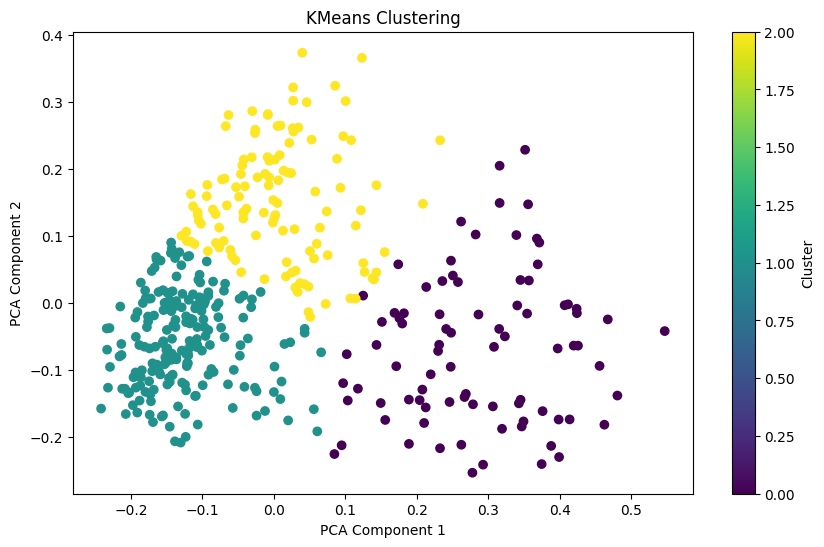

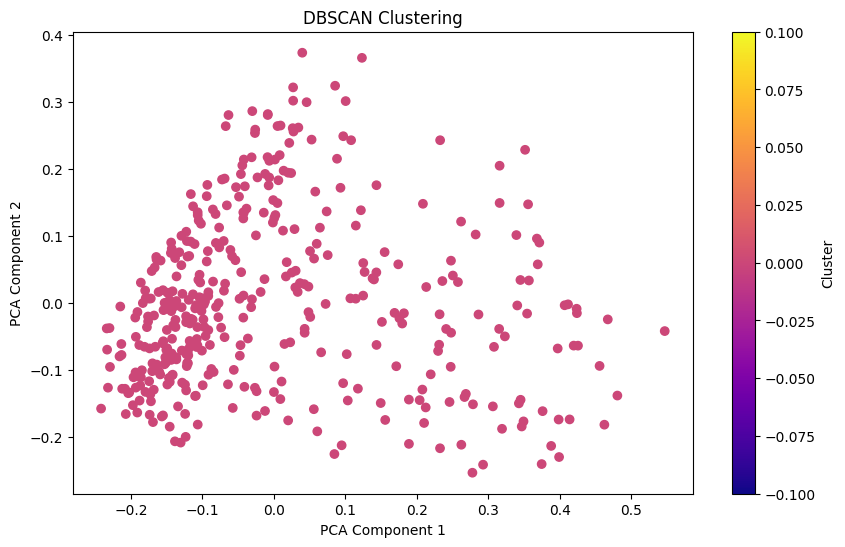

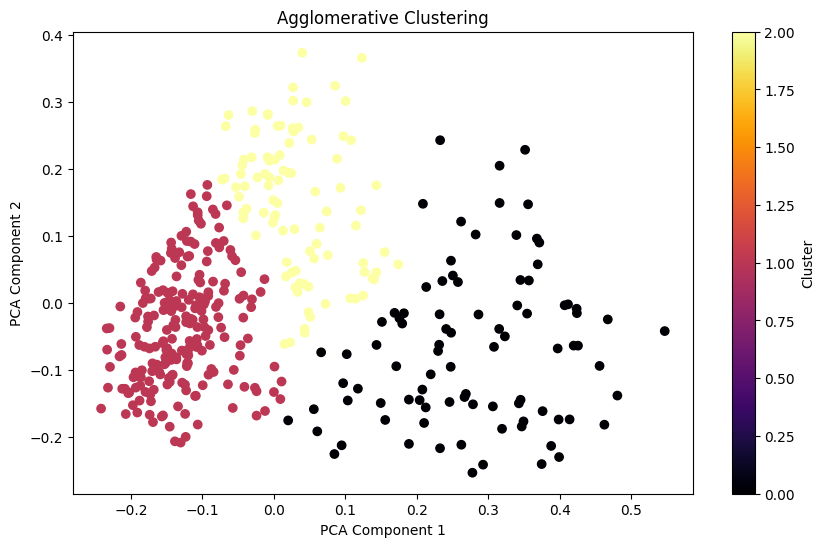

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5ForConditionalGeneration, PegasusTokenizer, PegasusForConditionalGeneration, BartTokenizer, BartForConditionalGeneration
from sklearn.feature_extraction.text import TfidfVectorizer
from rouge_score import rouge_scorer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Load the datasets from Google Colab (ensure you've uploaded them)
train_file = '/content/Train1000.csv'
generated_file = '/content/Generated_Train1000.csv'
final_combined_file = '/content/Final_Correct_Combined_Train1000.csv'

# Load the CSV files
train_df = pd.read_csv(train_file)
generated_df = pd.read_csv(generated_file)
final_combined_df = pd.read_csv(final_combined_file)

# Reduce dataset size for faster tests (limit to first 500 rows)
final_combined_df = final_combined_df.head(500)

# Assuming 'article' as input text and 'highlights' as the target text for summarization
X = final_combined_df['article']
y = final_combined_df['highlights']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Transformer-based Model Summarization (T5, PEGASUS, BART) ---
# Function for summarization
def summarize_model(model, tokenizer, texts, max_len=512, summary_len=150):
    try:
        inputs = tokenizer(texts, return_tensors="pt", max_length=max_len, truncation=True, padding="longest")
        summaries = model.generate(inputs['input_ids'], max_length=summary_len, num_beams=2, early_stopping=True)
        return [tokenizer.decode(s, skip_special_tokens=True) for s in summaries]
    except Exception as e:
        print(f"Error during summarization: {e}")
        return []

# --- T5 Model ---
try:
    t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
    t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')
    summaries_t5 = summarize_model(t5_model, t5_tokenizer, X_test[:5].tolist())
    print("\nT5 Summaries:", summaries_t5)
except Exception as e:
    print(f"T5 Model Error: {e}")

# --- PEGASUS Model ---
try:
    pegasus_tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')
    pegasus_model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')
    summaries_pegasus = summarize_model(pegasus_model, pegasus_tokenizer, X_test[:5].tolist())
    print("\nPEGASUS Summaries:", summaries_pegasus)
except Exception as e:
    print(f"PEGASUS Model Error: {e}")

# --- BART Model ---
try:
    bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
    summaries_bart = summarize_model(bart_model, bart_tokenizer, X_test[:5].tolist())
    print("\nBART Summaries:", summaries_bart)
except Exception as e:
    print(f"BART Model Error: {e}")

# --- Evaluation Functions ---
def evaluate_summaries_rouge(references, predictions):
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = [rouge.score(ref, pred) for ref, pred in zip(references, predictions)]
    return scores

def evaluate_summaries_bleu(references, predictions):
    smooth_fn = SmoothingFunction().method1  # Smoothing to handle brevity or missing n-grams
    scores = []
    for ref, pred in zip(references, predictions):
        reference_tokens = ref.split()  # Tokenize reference
        prediction_tokens = pred.split()  # Tokenize prediction
        score = sentence_bleu([reference_tokens], prediction_tokens, smoothing_function=smooth_fn)
        scores.append(score)
    return scores

# Prepare the ground-truth references
references = y_test[:5].tolist()

# --- Evaluate Transformer Models ---
def evaluate_summaries():
    # Evaluate T5
    if summaries_t5:
        t5_rouge_scores = evaluate_summaries_rouge(references, summaries_t5)
        t5_bleu_scores = evaluate_summaries_bleu(references, summaries_t5)
        print("\nROUGE Scores for T5:")
        for i, score in enumerate(t5_rouge_scores):
            print(f"Sample {i+1}: {score}")
        print("BLEU Scores for T5:", t5_bleu_scores)

    # Evaluate PEGASUS
    if summaries_pegasus:
        pegasus_rouge_scores = evaluate_summaries_rouge(references, summaries_pegasus)
        pegasus_bleu_scores = evaluate_summaries_bleu(references, summaries_pegasus)
        print("\nROUGE Scores for PEGASUS:")
        for i, score in enumerate(pegasus_rouge_scores):
            print(f"Sample {i+1}: {score}")
        print("BLEU Scores for PEGASUS:", pegasus_bleu_scores)

    # Evaluate BART
    if summaries_bart:
        bart_rouge_scores = evaluate_summaries_rouge(references, summaries_bart)
        bart_bleu_scores = evaluate_summaries_bleu(references, summaries_bart)
        print("\nROUGE Scores for BART:")
        for i, score in enumerate(bart_rouge_scores):
            print(f"Sample {i+1}: {score}")
        print("BLEU Scores for BART:", bart_bleu_scores)

evaluate_summaries()

# --- Clustering (KMeans, DBSCAN, Agglomerative Clustering) ---
# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)

# Apply PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_vec.toarray())  # Convert sparse matrix to dense for PCA

# --- KMeans Clustering ---
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_train_pca)
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.title("KMeans Clustering")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# --- DBSCAN Clustering ---
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_train_pca)
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=dbscan_labels, cmap='plasma', marker='o')
plt.title("DBSCAN Clustering")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# --- Agglomerative Clustering (Dendrogram) ---
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_clustering.fit_predict(X_train_pca)
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=agg_labels, cmap='inferno', marker='o')
plt.title("Agglomerative Clustering")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()
